In [1]:
import numpy as np
import cv2
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from scipy.ndimage.measurements import label

import os
%matplotlib inline

In [2]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [3]:
cars = glob.glob('vehicles/*/*.jpg')
print(len(cars))

8792


In [4]:
non_cars = glob.glob('non-vehicles/*/*.jpg')
print(len(non_cars))

8968


In [5]:
test_set = glob.glob('test_images/*')

In [6]:
def plot_image_set(images, titles, fig_name, image_type=None):
    """
    A plotting function for plotting images side by side
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(images[0], cmap=image_type)
    ax1.set_title(titles[0], fontsize=30)
    ax2.imshow(images[1], cmap=image_type)
    ax2.set_title(titles[1], fontsize=30)
    plt.savefig(fig_name)

In [7]:
params = dict()
params['color_space'] = 'HSV'
params['nbins'] = 52
params['bins_range'] = (0, 256)
params['resize_image_size'] = (16, 16)
params['orient'] = 12
params['pixels_per_cell'] = 8
params['cells_per_block'] = 2
params['hog_channel'] = 3

In [8]:
def color_hist(image, nbins=32, bins_range=(0, 256)):
    """
    Function to compute color histogram features
    Compute the histogram of the RGB channels separately
    Concatenate the histograms into a single feature vector
    Return the feature vector
    """
    channel1_hist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

In [9]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    """
    Define a function that takes an image, a color space, 
    and a new image size and returns a feature vector.
    """
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel()
    # Return the feature vector
    return features

In [10]:
def get_hog_features_plot(image, orient, pix_per_cell, cell_per_block):
    """
    Function to return HOG features
    """
    hog_features = []
    for color_channel in range(image.shape[2]):
        channel_features, hog_image = hog(image[:,:,color_channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                           visualise=True, feature_vector=False)
        hog_features.append(channel_features)
    hog_features = np.ravel(hog_features)    
    return hog_features, hog_image

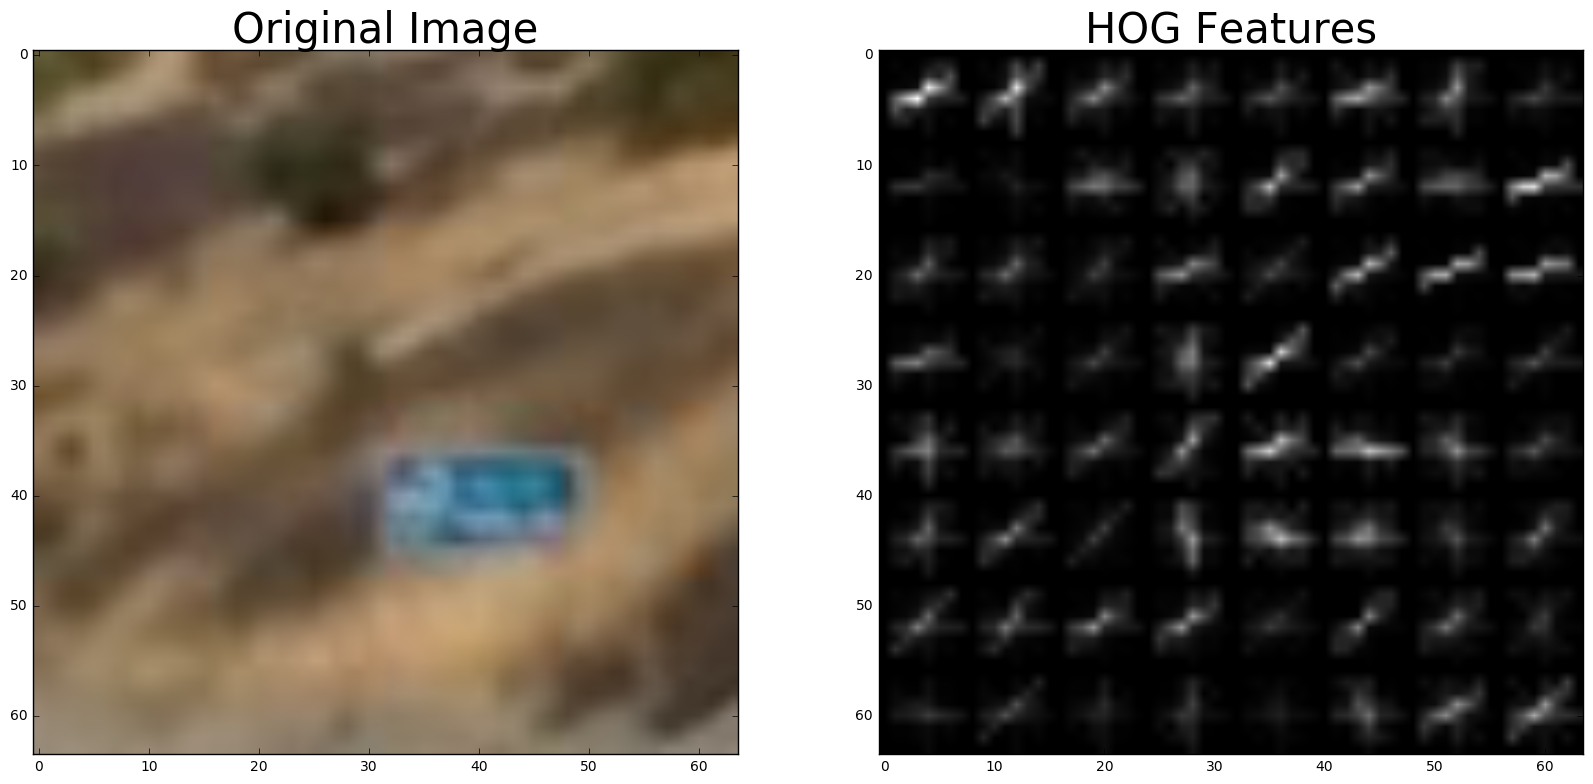

In [11]:
for image_path in non_cars[103:104]:
    test_img = mpimg.imread(image_path)
    features, res_img = get_hog_features_plot(test_img, orient=12, pix_per_cell=8, cell_per_block=2)
    plot_image_set([test_img, res_img], titles=['Original Image', 'HOG Features'], fig_name='hog_images_nocar', image_type='gray')

In [23]:
def get_hog_features(image, orient, pix_per_cell, cell_per_block):
    """
    Function to return HOG features
    """
    hog_features = []
    for color_channel in range(image.shape[2]):
        channel_features = hog(image[:,:,color_channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                           visualise=False, feature_vector=True)
        hog_features.append(channel_features)
    hog_features = np.ravel(hog_features)    
    return hog_features


def extract_features(images, params):
    """
    Function to extract all the features from a set of images
    """
    features = []
    for img_path in images:
        image = mpimg.imread(img_path)
        spatial_features = bin_spatial(image, size=params['resize_image_size'])
        hist_features = color_hist(image, nbins=params['nbins'], bins_range=params['bins_range'])
        hog_features = get_hog_features(image, params['orient'], params['pixels_per_cell'], params['cells_per_block'])
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    return features

In [24]:
 def single_img_features(image, params):
    """
    Extract features from only an image
    """
    spatial_features = bin_spatial(image, size=params['resize_image_size'])
    hist_features = color_hist(image, nbins=params['nbins'], bins_range=params['bins_range'])
    hog_features = get_hog_features(image, params['orient'], params['pixels_per_cell'], params['cells_per_block'])
    return np.concatenate((spatial_features, hist_features,hog_features))

In [11]:
# Get all the features from the dataset of vehicles
car_features = extract_features(cars, params)

In [12]:
# Get all the features from the dataset of non-vehicles
notcar_features = extract_features(non_cars, params)

In [13]:
def create_train_test_set(car_features, notcar_features):
    """
    Create a training and testing set.
    """
    X = np.vstack((np.array(car_features), np.array(notcar_features))).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    Y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size=0.2, random_state=1234)
    
    return X_train, Y_train, X_test, Y_test, X_scaler

In [26]:
# Apply the scaler to training and test sets
X_train, Y_train, X_test, Y_test, X_scaler = create_train_test_set(car_features, notcar_features)

In [27]:
def svm_classifier(X_train, Y_train, X_test, Y_test):
    """
    Support Vector Machine (SVM) classifier.
    """
    clf = SVC(C=1.0, probability=True)
    clf.fit(X_train, Y_train)
    print("Accuracy of classifier - {:.4f}".format(clf.score(X_test, Y_test)))
    return clf

In [39]:
model = svm_classifier(X_train, Y_train, X_test, Y_test)

Accuracy of classifier - 0.9932


In [17]:
import _pickle

In [ ]:
#save the classifer
with open('my_dumped_classifier.pkl', 'wb') as fid:
    _pickle.dump(model, fid)

In [18]:
#load the classifer
with open('my_dumped_classifier.pkl', 'rb') as fid:
    model_loaded = _pickle.load(fid)

In [25]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Function to draw the boxes with the given coordinates
    """
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    """
    Function that takes an image, start and stop positions 
    in both x and y, window size (x and y dimensions), and 
    overlap fraction (for both x and y)
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-nx_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def search_windows(img, windows, clf, scaler, params):
    """
    Function that takes an image and the list of windows 
    to be searched (output of slide_window())
    """
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, params)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [28]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [27]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_w, bbox_h = abs(bbox[1][0] - bbox[0][0]), abs(bbox[1][1] - bbox[0][1])
        if bbox[0][1] <= 300:
            continue
        if bbox[0][1] >= 600:
            continue
        if bbox[0][0] >= 1220:
            continue
        bbox_area = bbox_w * bbox_h
        if bbox_area <= 2500:
            continue
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [30]:
def image_pipeline(image, static_images=False):
    """
    Pipeline function to apply all the above defined funtions
    to the images
    """
    global prev_frame_heat
    image_copy = np.copy(image)
    
    windows1 = slide_window(image, x_start_stop=[640, 1280], y_start_stop=[400, 700], 
                xy_window=(64, 64), xy_overlap=(0.6, 0.6))
    
    windows2 = slide_window(image, x_start_stop=[640, 1280], y_start_stop=[400, 700], 
                xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    
    windows3 = slide_window(image, x_start_stop=[640, 1280], y_start_stop=[400, 700], 
                xy_window=(128, 128), xy_overlap=(0.8, 0.8))

    windows = windows1 + windows2 + windows3 

    hot_windows = search_windows(image, windows, model_loaded, X_scaler, params)                  

    heat_image = np.zeros_like(image[:,:,0]).astype(np.float)

    add_heat(heat_image, hot_windows)
    
    '''Apply Simple Exponential Filter'''
    if not static_images:
        if prev_frame_heat == None:
            prev_frame_heat = heat_image
        else:
            heat_image = (prev_frame_heat * 0.2) + (heat_image * 0.8)
            prev_frame_heat = heat_image
        
    heatmaps = apply_threshold(heat_image, 2)
    labels = label(heatmaps)
    
    final_image = draw_labeled_bboxes(np.copy(image), labels)
    return final_image

In [31]:
for image_path in test_set:
    test_img = mpimg.imread(image_path)
    res_img = image_pipeline(test_img, static_images=True)
    plot_image_set([test_img, res_img], titles=['Original Image', 'Vehicles'], fig_name='final_output')

NameError: name 'model_loaded' is not defined

In [ ]:
def process_image(image):
    """
    Apply the functions defined to the image
    """
    result = image_pipeline(image)
    return result

prev_frame_heat = None
output_clip = 'p5_result.mp4'
input_clip = VideoFileClip("project_video.mp4")
clip = input_clip.fl_image(process_image)
%time clip.write_videofile(output_clip, audio=False)

HTML("""
<video width="1280" height="640" controls>
  <source src="{0}">
</video>
""".format(output_clip))